<a href="https://colab.research.google.com/github/HegdeSiddesh/cs6910_Assignment2/blob/main/Part%20B/Part_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Part B : Fine-tuning a pre-trained model



### Import required packages

In [ ]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import random
np.random.seed(137) # To ensure that the random number generated are the same for every iteration
import warnings
#warnings.filterwarnings("ignore")
!pip install --upgrade wandb
import wandb
import tensorflow as tf
from tensorflow import keras
from keras import datasets, layers, models
from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
import os
from keras.datasets import fashion_mnist
from keras.layers.convolutional import Conv2D
from keras.layers import Dense, Flatten, InputLayer
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Activation
from wandb.keras import WandbCallback
from google.colab.patches import cv2_imshow
from keras.callbacks import EarlyStopping
tf.random.set_seed(137)

In [ ]:
wandb.login()

wandb: Currently logged in as: hithesh-sidhesh (use `wandb login --relogin` to force relogin)


True

In [ ]:
#Download and unzip the iNaturalist dataset
!wget https://storage.googleapis.com/wandb_datasets/nature_12K.zip
!unzip -q /content/nature_12K.zip

--2022-03-30 20:32:38--  https://storage.googleapis.com/wandb_datasets/nature_12K.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.157.128, 142.251.8.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.157.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3816687935 (3.6G) [application/zip]
Saving to: ‘nature_12K.zip.1’

nature_12K.zip.1      8%[>                   ] 293.35M   203MB/s               ^C
replace inaturalist_12K/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
#GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Mar 30 20:32:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
wandb.init(project="Assignment_2", entity="hithesh-sidhesh", name="Part_B")

(600, 800, 3)
The image consists of 480000 pixels


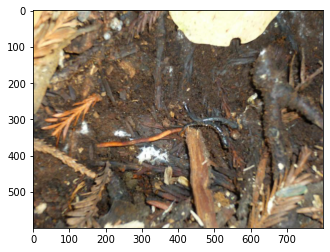

In [ ]:
#To find the shape of the image
os.chdir("/content/inaturalist_12K/train/Amphibia")
img=plt.imread("0012ec13b97dfbfb3dd5de8c3da95555.jpg")
print(img.shape)
print("The image consists of %i pixels" % (img.shape[0] * img.shape[1]))
plt.imshow(img);

In [ ]:
def datagen(augment_data):

  ##################################################Initialize data generation pipeling ########################################################
  #Splitting training data into train and validation sets

  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,validation_split=0.1)
  IMG_SIZE = (128,128)
  batch_size = 32
  if augment_data==True:  
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,rotation_range=90, zoom_range=0.2, shear_range=0.2, horizontal_flip=True,validation_split=0.1)

  else:
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,validation_split=0.1)

  
  train_gen = train_datagen.flow_from_directory(
          '/content/inaturalist_12K/train',
          target_size=IMG_SIZE,
          subset = 'training',
              batch_size=batch_size,
              class_mode='categorical',
              shuffle = True,
          seed = 137)
  print('TRAINING')
  print('Number of samples', train_gen.samples)
  print('Names of classes', train_gen.class_indices)
  print('Number of classes', len(train_gen.class_indices))
  print('Number of samples per class', int(train_gen.samples / len(train_gen.class_indices) ))

  validation_gen = train_datagen.flow_from_directory(
          '/content/inaturalist_12K/train',
          target_size=IMG_SIZE,
              subset = 'validation',
              batch_size=batch_size,
              class_mode='categorical',
              shuffle = False,
          seed = 137)
  print('VALIDATION')
  print('Number of samples', validation_gen.samples)
  print('Names of classes', validation_gen.class_indices)
  print('Number of classes', len(validation_gen.class_indices))
  print('Number of samples per class', int(validation_gen.samples / len(validation_gen.class_indices) ))

  train_generator = tf.data.Dataset.from_generator(
    lambda: train_gen,
    output_types = (tf.float32, tf.float32)
    ,output_shapes = ([None, 128, 128, 3], [None, 10]),
  )
  #train_generator = train_generator.shuffle(buffer_size=1000)
  #train_generator = train_generator.batch(32)
  train_generator = train_generator.repeat()
  train_generator = train_generator.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

  validation_generator = tf.data.Dataset.from_generator(
      lambda: validation_gen,
      output_types = (tf.float32, tf.float32)
      ,output_shapes = ([None, 128, 128, 3], [None, 10]),
  )
  #validation_generator = validation_generator.shuffle(buffer_size=1000)
  #validation_generator = validation_generator.batch(32)
  validation_generator = validation_generator.repeat()
  validation_generator = validation_generator.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

  ##########################Prepare test data###########################################
  IMG_SIZE = (128,128)

  test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
  test_gen = test_datagen.flow_from_directory(
          '/content/inaturalist_12K/val',
          target_size=IMG_SIZE,
              batch_size=32,
              class_mode='categorical',
              shuffle = False,
          seed = 137)
  test_generator = tf.data.Dataset.from_generator(
      lambda: test_gen,
      output_types = (tf.float32, tf.float32)
      ,output_shapes = ([None, 128, 128, 3], [None, 10]),
  )
  test_generator = test_generator.repeat()
  test_generator = test_generator.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

  
  return train_generator , validation_generator , test_gen ,batch_size , train_gen , validation_gen , train_gen.batch_size , validation_gen.batch_size , train_gen.samples , validation_gen.samples , test_gen.samples , test_gen.batch_size
  

In [ ]:
#Reference link :- https://keras.io/api/applications/#usage-examples-for-image-classification-models
# After comparing all the 40 pre-trained models in keras , we have shortlisted these 4 models based on the Top-1 accuracy, Top-5 accuracy , Number of parameters and Time(ms) per inference step (GPU).
from tensorflow.keras.applications import ResNet50V2           
from tensorflow.keras.applications import Xception              
from tensorflow.keras.applications import MobileNetV2           
from tensorflow.keras.applications import EfficientNetB3        



In [ ]:
###############################################
# Listing the hyperparameters in wandb config 
###############################################
sweep_config = {
    'method': 'bayes', #grid, random
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'model':{
            'values':['resnet','xception', 'efficientnet','mobilenet']
        },
        #excluding output layer
        'dense_layers': {
            'values': [0,1,2]
        },
        'size_layer': {
            'values': [32, 64, 128]
        },
        #100% means no fine tuning, only pre training
        'layers_freeze':{
            'values': [60,70,80,100]
        
        },
        'dropout': {
            'values':[0.01,0.2,0.5,0.8]
        },
        'augment_data': {
            'values': ['yes', 'no']
        },

    }
}

In [ ]:
sweep_id = wandb.sweep(sweep_config,project="Assignment_2", entity="hithesh-sidhesh" )

Create sweep with ID: ns0reusj
Sweep URL: https://wandb.ai/hithesh-sidhesh/Assignment_2/sweeps/ns0reusj


In [ ]:
def modelname(keras_model):

  # Each Keras Application expects a specific kind of input preprocessing . 
  #(For Xception, call tf.keras.applications.xception.preprocess_input for pre-processing the input)
  lib="tf.keras.applications."

  if keras_model=="resnet":
    print("Resnet chosen")
    name1="resnet_v2"
    modelname=ResNet50V2
  elif keras_model=="xception":
    print("Xception chosen")                   
    name1="xception"
    modelname=Xception
  elif keras_model=="mobilenet":
    print("Mobilenet chosen")
    name1="mobilenet_v2"
    modelname=MobileNetV2
  elif keras_model=="efficientnet":
    print("EfficientNetB3 chosen")
    name1="efficientnet"
    modelname=EfficientNetB3
  
  #preprocessing the input
  preprocess_input = eval(lib+name1+".preprocess_input")
  
  base_model = Sequential()
  base_model.add(modelname(include_top=False,input_shape=(128,128,3),weights='imagenet',pooling='avg'))

  return preprocess_input , base_model


In [ ]:
#Reference link for transfer learning using a pre-trained model :- https://developer.ridgerun.com/wiki/index.php?title=Keras_with_MobilenetV2_for_Deep_Learning
#                                                                  https://keras.io/guides/transfer_learning/ 
def train():

  config_defaults = {
        'model': 'efficientnet',
        'dense_layers':1 ,
        'size_layer':64 ,
        'layers_freeze':70 ,
        'augment_data' : 'no',
        'dropout' : 0.2
  }
    
  with wandb.init(project='Assignment_2',config = sweep_config, name="Part B"):
    config = wandb.init().config

    #Setting custom run name 
    wandb.run.name = config.model + '_dense_layers_' + str(config.dense_layers) + '_size_layer_' + str(config.size_layer) + '_layers_freeze_' + str(config.layers_freeze) +'_augment_data_' + config.augment_data + '_dropout_' + str(config.dropout) 
    
    keras_model = config.model
    preprocess_input,base_model = modelname(config.model)
    #freezing the base model
    base_model.trainable = False

    base_model.add(Flatten()) # The flatten layer is essential to convert the feature map into a column vector
    for i in range(config.dense_layers):
      base_model.add(Dense(config.size_layer, activation='relu')) #add a dense layer
      base_model.add(tf.keras.layers.Dropout(config.dropout))

    base_model.add(Dense(10, activation="softmax")) # we have 10 classes

    base_model.summary()

    #set the learning rate . It's also critical to use a very low learning rate at this stage, 
    #because you are training a much larger model than in the first round of training, 
    #on a dataset that is typically very small. 
    #As a result, you are at risk of overfitting very quickly if you apply large weight updates. 
    #Here, you only want to readapt the pretrained weights in an incremental way.

    #Train the top layer

    base_learning_rate = 0.0001

    #Train the model on new data.
    base_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    #Early Stopping callback
    earlyStopping = EarlyStopping(monitor='val_loss', patience=6, verbose=2, mode='min')

    #Epochs for pre training 
    initial_epochs = 10
    
    train_generator , validation_generator , test_gen , batch_size , train_gen , validation_gen , train_gen.batch_size , validation_gen.batch_size , train_gen.samples , validation_gen.samples , test_gen.samples ,test_gen.batch_size = datagen(config.augment_data)
    
    
    hist = base_model.fit(train_generator,
                     epochs=initial_epochs,
                     batch_size=batch_size,
                     steps_per_epoch = train_gen.samples//train_gen.batch_size,
                     validation_data=validation_generator,
                     validation_steps= validation_gen.samples//validation_gen.batch_size,
                     verbose=2,
                     callbacks=[WandbCallback(data_type="image", generator=validation_generator) , earlyStopping ]
                    )
    
    #Do a round of fine-tuning of the entire model
    # Unfreeze the base_model. Note that it keeps running in inference mode
    # since we passed `training=False` when calling it. This means that
    # the batchnorm layers will not update their batch statistics.
    # This prevents the batchnorm layers from undoing all the training
    # we've done so far.
    import math 
    if config.layers_freeze !=100:
      #unfreeze the base model
      base_model.trainable = True
      # Fine-tune from this layer onwards
      fine_tune_at = math.floor((config.layers_freeze/100.0)*len(base_model.layers))
      # Freeze all the layers before the "fine_tune_at" layer
      for layer in base_model.layers[:fine_tune_at]:
          #freeze 
        layer.trainable =  False
      base_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),loss = 'categorical_crossentropy',metrics=['accuracy'])
        
      
  
        #fine tune epochs 
      fine_tune_epochs = 10
      total_epochs =  initial_epochs + fine_tune_epochs
      hist_fine = base_model.fit(train_generator,
                             epochs=total_epochs,
                             initial_epoch=hist.epoch[-1]+1,
                             validation_data=validation_generator,
                             batch_size=batch_size,
                             steps_per_epoch = train_gen.samples//train_gen.batch_size,
                             validation_steps= validation_gen.samples//validation_gen.batch_size,
                             verbose=2,
                             callbacks=[WandbCallback(data_type="image", generator=validation_generator) , earlyStopping]
                            )
      
    test_loss, test_acc = base_model.evaluate(test_gen , steps=test_gen.samples//test_gen.batch_size, verbose=2)
    
    if config.layers_freeze !=100:
      val_acc=max(hist_fine.history['val_accuracy'])
      train_acc=max(hist_fine.history['accuracy'])
      val_loss=max(hist_fine.history['val_loss'])
      train_loss=max(hist_fine.history['loss']) 
    else:
      val_acc=max(hist.history['val_accuracy'])
      train_acc=max(hist.history['accuracy'])
      val_loss=max(hist.history['val_loss'])
      train_loss=max(hist.history['loss']) 

    log_values = {'Training_loss':train_loss, 'Validation_loss':val_loss, 'Training_accuracy':train_acc, 'Validation_accuracy':val_acc}
    print('Test accuracy on model is : ',test_acc)
    wandb.log(log_values)
    print(log_values)
    wandb.log({"accuracy": val_acc})
    wandb.run.save()
    wandb.run.finish()
    return base_model


In [ ]:
#################################
# Setting up wandb sweeps
#################################
wandb.agent(sweep_id, train , count = 15 )


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: q25izwld with config:
wandb: 	augment_data: yes
wandb: 	dense_layers: 0
wandb: 	dropout: 0.5
wandb: 	layers_freeze: 100
wandb: 	model: mobilenet
wandb: 	size_layer: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Mobilenet chosen
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 0
Non-trainable params: 2,270,794
_________________________________________________________________
Found 10037 images belonging to 10 classes.
TRAINING
Number of samples 10037
Names of classes {'Amphibia': 0, 'Animalia': 1, 'Arachnida': 2, 'Aves': 3, 'Fungi': 4, 'Insecta': 5, 'Mammalia': 6, 'Mollusca': 7, 'Plantae': 8, 'Rept

wandb: WARNING The data_type argument of wandb.keras.WandbCallback is deprecated and will be removed in a future release. Please use input_type instead.
wandb: WARNING Setting input_type = data_type.


Epoch 1/10
313/313 - 105s - loss: 2.8956 - accuracy: 0.1026 - val_loss: 2.8893 - val_accuracy: 0.0993 - _timestamp: 1648672504.0000 - _runtime: 113.0000 - 105s/epoch - 336ms/step
Epoch 2/10
313/313 - 99s - loss: 2.8944 - accuracy: 0.1022 - val_loss: 2.8941 - val_accuracy: 0.0961 - _timestamp: 1648672603.0000 - _runtime: 212.0000 - 99s/epoch - 315ms/step
Epoch 3/10
313/313 - 98s - loss: 2.8943 - accuracy: 0.1031 - val_loss: 2.8992 - val_accuracy: 0.0952 - _timestamp: 1648672702.0000 - _runtime: 311.0000 - 98s/epoch - 313ms/step
Epoch 4/10
313/313 - 98s - loss: 2.8964 - accuracy: 0.1028 - val_loss: 2.8889 - val_accuracy: 0.0998 - _timestamp: 1648672799.0000 - _runtime: 408.0000 - 98s/epoch - 312ms/step
Epoch 5/10
313/313 - 95s - loss: 2.8966 - accuracy: 0.1018 - val_loss: 2.8958 - val_accuracy: 0.0980 - _timestamp: 1648672894.0000 - _runtime: 503.0000 - 95s/epoch - 302ms/step
Epoch 6/10
313/313 - 91s - loss: 2.8938 - accuracy: 0.1030 - val_loss: 2.8880 - val_accuracy: 0.0998 - _timestamp

wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Test accuracy on model is :  0.09526209533214569
{'Training_loss': 2.8968002796173096, 'Validation_loss': 2.8991551399230957, 'Training_accuracy': 0.1034482792019844, 'Validation_accuracy': 0.10536044090986252, '_timestamp': 1648673357, '_runtime': 966}



Training_accuracy,▁
Training_loss,▁
Validation_accuracy,▁
Validation_loss,▁
accuracy,▃▂▄▃▁▄▃▃▄▁█
epoch,▁▂▃▃▄▅▆▆▇█
loss,▆▅▄▇█▄▅▁▆█
val_accuracy,▄▂▁▄▃▄▆███
val_loss,▇▇█▇█▇▆▁▁▃
Training_accuracy,0.10345
Training_loss,2.8968


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: if03h48j with config:
wandb: 	augment_data: yes
wandb: 	dense_layers: 2
wandb: 	dropout: 0.5
wandb: 	layers_freeze: 70
wandb: 	model: efficientnet
wandb: 	size_layer: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


EfficientNetB3 chosen
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 64)                98368     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None

Training_accuracy,▁
Training_loss,▁
Validation_accuracy,▁
Validation_loss,▁
accuracy,▁▁▁▂▁▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄█
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,██▇▇████▇█▇▆▅▄▄▃▂▂▂▁
val_accuracy,▁▂▂▂▂▂▂▂▂▂▂▂▂▂▃█████
val_loss,█▇▇▇▇▇▇▇▇▇▆▅▄▄▃▃▂▂▁▁
Training_accuracy,0.14544
Training_loss,2.38341


wandb: Agent Starting Run: vub6oukd with config:
wandb: 	augment_data: yes
wandb: 	dense_layers: 1
wandb: 	dropout: 0.2
wandb: 	layers_freeze: 70
wandb: 	model: xception
wandb: 	size_layer: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Xception chosen
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 21,125,042
Trainable params: 0
Non-trainable params: 21,125,042
_________________________________________________________________
Found 10901 images belonging

Training_accuracy,▁
Training_loss,▁
Validation_accuracy,▁
Validation_loss,▁
accuracy,▁▁▁▁▁▂▁▂▁▂▂▂▂▂▃▃▄▅▆▆█
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,██████████▇▆▅▅▄▃▃▂▁▁
val_accuracy,▂▂▂▂▂▂▂▂▂▂▁▁▃▃▃▄▄▅▇█
val_loss,██████████▇▆▅▄▃▃▃▂▁▁
Training_accuracy,0.13957
Training_loss,2.60776


wandb: Agent Starting Run: cv9yb1su with config:
wandb: 	augment_data: yes
wandb: 	dense_layers: 2
wandb: 	dropout: 0.5
wandb: 	layers_freeze: 80
wandb: 	model: mobilenet
wandb: 	size_layer: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Mobilenet chosen
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                       

Training_accuracy,▁
Training_loss,▁
Validation_accuracy,▁
Validation_loss,▁
accuracy,▂▂▂▂▂▂▂▂▁▁▁▂▃▃▃▅▆▆▇█▇
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,███▇██████▇▆▅▄▄▃▂▂▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▄▅▇█
val_loss,██████████▇▆▅▄▄▃▂▂▁▁
Training_accuracy,0.13028
Training_loss,3.2698


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8clhcg44 with config:
wandb: 	augment_data: yes
wandb: 	dense_layers: 2
wandb: 	dropout: 0.2
wandb: 	layers_freeze: 100
wandb: 	model: mobilenet
wandb: 	size_layer: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Mobilenet chosen
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 64)                81984     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                       

Training_accuracy,▁
Training_loss,▁
Validation_accuracy,▁
Validation_loss,▁
accuracy,▆▃▄▇█▇▆▆▇▆▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▂▇▄▂▃▁▇▄
val_accuracy,▁█████████
val_loss,█▄▄▁▃▂▄▂▂▂
Training_accuracy,0.07969
Training_loss,2.86103


wandb: Agent Starting Run: 6xn8qm85 with config:
wandb: 	augment_data: yes
wandb: 	dense_layers: 1
wandb: 	dropout: 0.5
wandb: 	layers_freeze: 60
wandb: 	model: resnet
wandb: 	size_layer: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Resnet chosen
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 32)                65568     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                                 
Total params: 23,630,698
Trainable params: 0
Non-trainable params: 23,630,698
_________________________________________________________________
Found 12341 images belonging t

Training_accuracy,▁
Training_loss,▁
Validation_accuracy,▁
Validation_loss,▁
accuracy,▁▁▁▂▁▁▁▁▁▁▁▂▂▂▂▃▂▃▃▄█
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,▇███▇█▇▇▇█▇▆▇▅▄▃▃▂▂▁
val_accuracy,▁▁▂▁▁▂▁▁▁▁▂▃▃▄▅▅▆▇▇█
val_loss,██████████▇▆▆▅▄▃▃▂▂▁
Training_accuracy,0.14591
Training_loss,3.52806


wandb: Agent Starting Run: kly43e17 with config:
wandb: 	augment_data: no
wandb: 	dense_layers: 0
wandb: 	dropout: 0.2
wandb: 	layers_freeze: 60
wandb: 	model: efficientnet
wandb: 	size_layer: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


EfficientNetB3 chosen
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 10)                15370     
                                                                 
Total params: 10,798,905
Trainable params: 0
Non-trainable params: 10,798,905
_________________________________________________________________
Found 12917 images belonging to 10 classes.
TRAINING
Number of samples 12917
Names of classes {'Amphibia': 0, 'Animalia': 1, 'Arachnida': 2, 'Aves': 3, 'Fungi': 4, 'Insecta': 5, 'Mammalia': 6, 'Mollusca': 7, 'Plantae': 8, 'Reptilia': 9}
Number of classes 10
Number of samples per class 

Training_accuracy,▁
Training_loss,▁
Validation_accuracy,▁
Validation_loss,▁
accuracy,▁▁▁▁▁▁▁▇█████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,███████▄▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▇▇▇▇▇▇▇▇█████
val_loss,███████▃▂▂▂▂▂▂▂▂▁▁▁▁
Training_accuracy,0.37936
Training_loss,2.16838


wandb: Agent Starting Run: wec0wqlj with config:
wandb: 	augment_data: no
wandb: 	dense_layers: 0
wandb: 	dropout: 0.2
wandb: 	layers_freeze: 100
wandb: 	model: efficientnet
wandb: 	size_layer: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


EfficientNetB3 chosen
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 10)                15370     
                                                                 
Total params: 10,798,905
Trainable params: 0
Non-trainable params: 10,798,905
_________________________________________________________________
Found 13493 images belonging to 10 classes.
TRAINING
Number of samples 13493
Names of classes {'Amphibia': 0, 'Animalia': 1, 'Arachnida': 2, 'Aves': 3, 'Fungi': 4, 'Insecta': 5, 'Mammalia': 6, 'Mollusca': 7, 'Plantae': 8, 'Reptilia': 9}
Number of classes 10
Number of samples per class 

Training_accuracy,▁
Training_loss,▁
Validation_accuracy,▁
Validation_loss,▁
accuracy,▃▂▄▃▂▃▁█
epoch,▁▂▃▅▆▇█
loss,▁▁▃▁▂█▇
val_accuracy,▁██████
val_loss,▁▇█▇██▇
Training_accuracy,0.06701
Training_loss,2.3265


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: v4s0rkqc with config:
wandb: 	augment_data: yes
wandb: 	dense_layers: 0
wandb: 	dropout: 0.01
wandb: 	layers_freeze: 60
wandb: 	model: efficientnet
wandb: 	size_layer: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


EfficientNetB3 chosen
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 10)                15370     
                                                                 
Total params: 10,798,905
Trainable params: 0
Non-trainable params: 10,798,905
_________________________________________________________________
Found 13695 images belonging to 10 classes.
TRAINING
Number of samples 13695
Names of classes {'Amphibia': 0, 'Animalia': 1, 'Arachnida': 2, 'Aves': 3, 'Fungi': 4, 'Insecta': 5, 'Mammalia': 6, 'Mollusca': 7, 'Plantae': 8, 'Reptilia': 9}
Number of classes 10
Number of samples per class 

Training_accuracy,▁
Training_loss,▁
Validation_accuracy,▁
Validation_loss,▁
accuracy,▁▁▁▁▁▁▁▁▁▁▆██████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,██████████▄▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁██████████
val_loss,██████████▂▂▂▂▂▂▂▂▁▁
Training_accuracy,0.4117
Training_loss,2.15771


wandb: Agent Starting Run: kyams4gm with config:
wandb: 	augment_data: yes
wandb: 	dense_layers: 2
wandb: 	dropout: 0.2
wandb: 	layers_freeze: 70
wandb: 	model: xception
wandb: 	size_layer: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Xception chosen
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 32)                65568     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 10) 

Training_accuracy,▁
Training_loss,▁
Validation_accuracy,▁
Validation_loss,▁
accuracy,▁▁▁▁▁▁▁▁▂▂▃▄▅▆▆▇▇▇███
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,███████▇▆▆▅▄▃▃▂▂▂▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▂▃▅▆▇███████
val_loss,███████▇▆▅▄▄▃▃▂▂▂▁▁▁
Training_accuracy,0.40782
Training_loss,2.37476


wandb: Agent Starting Run: kfkq3ndc with config:
wandb: 	augment_data: no
wandb: 	dense_layers: 0
wandb: 	dropout: 0.2
wandb: 	layers_freeze: 70
wandb: 	model: xception
wandb: 	size_layer: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Xception chosen
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 20,881,970
Trainable params: 0
Non-trainable params: 20,881,970
_________________________________________________________________
Found 14847 images belonging to 10 classes.
TRAINING
Number of samples 14847
Names of classes {'Amphibia': 0, 'Animalia': 1, 'Arachnida': 2, 'Aves': 3, 'Fungi': 4, 'Insecta': 5, 'Mammalia': 6, 'Mollusca': 7, 'Plantae': 8, 'Reptilia': 9}
Number of classes 10
Number of samples per class 1484
F

Training_accuracy,▁
Training_loss,▁
Validation_accuracy,▁
Validation_loss,▁
accuracy,▁▁▁▁▁▁▁▁▁▁▄▆▆▇▇▇▇▇▇██
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,██████████▅▄▃▃▂▂▂▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▆▆▇▇▇▇████
val_loss,██████████▄▄▃▃▂▂▂▁▁▁
Training_accuracy,0.52076
Training_loss,2.20089


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ijdnec34 with config:
wandb: 	augment_data: no
wandb: 	dense_layers: 0
wandb: 	dropout: 0.8
wandb: 	layers_freeze: 80
wandb: 	model: efficientnet
wandb: 	size_layer: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


EfficientNetB3 chosen
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 10)                15370     
                                                                 
Total params: 10,798,905
Trainable params: 0
Non-trainable params: 10,798,905
_________________________________________________________________
Found 15423 images belonging to 10 classes.
TRAINING
Number of samples 15423
Names of classes {'Amphibia': 0, 'Animalia': 1, 'Arachnida': 2, 'Aves': 3, 'Fungi': 4, 'Insecta': 5, 'Mammalia': 6, 'Mollusca': 7, 'Plantae': 8, 'Reptilia': 9}
Number of classes 10
Number of samples per class 